## Sentiment Analysis using Neural Network

In [ ]:
import pandas as pd
import collections
import numpy as np
#Libraries for NLP
import re #for regex removal
import nltk
nltk.download('punkt') #for tokenization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #for removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer #for lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from functools import reduce #concatenate words into sentence using reduce
#Libraries for Transforming Data
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
#Libraries for neural network model
from keras.models import Sequential
from keras.layers import Dense
#Libraries for callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#Constants
VOCAB_SIZE = 10000  # Parameter indicating the number of words we'll put in the dictionary

### 1.Load Dataset Files  <a id="load_data">

In [ ]:
df1 = pd.read_csv("/content/US Airline Twitter Sentiment Analysis.csv", usecols=['text', 'airline_sentiment'])
print(f"df shape: {df.shape}")

df shape: (14640, 2)


In [ ]:
df1.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
df1['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### 2.Data Wrangling <a id="preprocess_data">

#### 2.1. Preprocessing

In [ ]:
#Customize stopwords list
for i in ["not", "no"]:
    stop_words.remove(i)
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_doc(doc):
    #1. Removing URLS
    doc = re.sub('http\S+', '', doc).strip()
    doc = re.sub('www\S+', '', doc).strip()
    #2. Removing upper brackets to keep words like [user\'s]
    doc = doc.replace("\'", "")
    #3. Removing symbols and numbers
    doc = re.sub(r"[^a-zA-Z]+", ' ', doc).strip()

    #4. Convert string to tokens, lowercase it & remove stop words
    tokens = word_tokenize(doc)  #to convert a string to tokens
    tokens = tokens = [w.lower() for w in tokens if w.lower() not in stop_words and len(w)>1]

    #5. Remove airline names tokens
    airlines = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways', 'americanair', 'jetblue'] #[re.sub(r" ", '', name.lower()) for name in airline_names]
    tokens = [word if word not in airlines else 'airline' for word in tokens]

    #6. Reducing repeated characters
    tokens = [re.sub(r"(.)\1{2,}", r"\1"*2, word) for word in tokens]

    #7. Convert word to its base form
    lemmatized_tokens = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    #8. Convert list of words into sentence
    doc = " ".join(lemmatized_tokens)
    return doc

In [ ]:
def preprocess_corpus(data):
    docs = [preprocess_doc(doc) for doc in data]
    return docs

In [ ]:
df1.text = df1.text.apply(preprocess_doc)

In [ ]:
df1.head()

,text,airline_sentiment
0,airline dhepburn say,neutral
1,airline plus youve added commercial experience...,positive
2,airline didnt today must mean need take anothe...,neutral
3,airline really aggressive blast obnoxious ente...,negative
4,airline really big bad thing,negative


In [ ]:
#Count total words in tweets
total_words = [word for doc in df1.text.values.tolist() for word in str.split(doc)]
print(f"total words: {len(total_words)}, unique words: {len(set(total_words))}")

total words: 149754, unique words: 10244


#### 2.2. Train Test Split

In [ ]:
def get_sentiment_distribution(data):
    pos_count = len([1 for val in data if val == 'positive'])
    neg_count = len([1 for val in data if val == 'negative'])
    neutral_count = len([1 for val in data if val == 'neutral'])
    print(f"positive = {pos_count}, negative = {neg_count}, neutral = {neutral_count}")

In [ ]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(df1['text'], df1['airline_sentiment'], test_size=0.30, shuffle=True, random_state=1, stratify=df1['airline_sentiment'])
print(f"train data: {len(y_train)}")
get_sentiment_distribution(y_train)
print(f"test data: {len(y_test)}")
get_sentiment_distribution(y_test)

train data: 10248
positive = 1654, negative = 6425, neutral = 2169
test data: 4392
positive = 709, negative = 2753, neutral = 930


#### 2.3. Converting words to numbers

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tokenizer.fit_on_texts(x_train)

In [ ]:
print('total number of documents used for fitting the tokenizer: {}'.format(tokenizer.document_count))
print('total words in dictionary: {}'.format(tokenizer.num_words))
print('dictionary of words along with the counts: {}', collections.Counter(tokenizer.word_counts).most_common(10))

total number of documents used for fitting the tokenizer: 10248
total words in dictionary: 10000
dictionary of words along with the counts: {} [('airline', 11314), ('flight', 3315), ('get', 1477), ('not', 1121), ('no', 1061), ('hour', 797), ('thanks', 762), ('service', 722), ('cancel', 708), ('customer', 660)]


In [ ]:
x_train_oh = tokenizer.texts_to_matrix(texts = x_train, mode='binary')
x_test_oh = tokenizer.texts_to_matrix(texts = x_test, mode='binary')

print('"{}" is converted into {}'.format(x_train[1], x_train_oh[1]))

"airline plus youve added commercial experience tacky" is converted into [0. 1. 0. ... 0. 0. 0.]


In [ ]:
print(f"no. of 1's: {sum(x_train_oh[1])}, length of encoding: {len(x_train_oh[1])}")

no. of 1's: 8.0, length of encoding: 10000


#### 2.4. Converting the target classes to numbers

In [ ]:
n = 0
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[n], y_train_le[n]))
print('"{}" is converted into {}'.format(y_train_le[n], y_train_oh[n]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


In [ ]:
y_train_oh[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

#### 2.5. Train Validation Split

In [ ]:
#Train Validation Split
x_train_oh1, x_valid_oh, y_train_oh1, y_valid_oh = train_test_split(x_train_oh, y_train_oh, test_size=0.1, random_state=1)
#print('Shape of validation set:',x_valid_oh.shape)

### 3.Model Train <a id='train_nn_system'>
- [TensorBoard Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

#### 3.1.Model Architecture 1

In [ ]:
#Model-1
mlp_model = Sequential(name = 'mlp_model_1')
mlp_model.add(Dense(64, activation='relu', input_shape=(VOCAB_SIZE,), name='layer_1'))
mlp_model.add(Dense(64, activation='relu', name='layer_2'))
mlp_model.add(Dense(3, activation='softmax', name='layer_3')) #o/p probability of 3 classes
mlp_model.summary()

Model: "mlp_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 64)                640064    
                                                                 
 layer_2 (Dense)             (None, 64)                4160      
                                                                 
 layer_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


#### 3.2.Model Architecture 2

In [ ]:
#Model-2
mlp_model2 = Sequential(name = 'mlp_model_2')
mlp_model2.add(Dense(32, activation='relu', input_shape=(VOCAB_SIZE,), name='layer_1'))
mlp_model2.add(Dense(3, activation='softmax', name='layer_2')) #o/p probability of 3 classes
mlp_model2.summary()

Model: "mlp_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 32)                320032    
                                                                 
 layer_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


#### 3.3.Model Architecture 3

In [ ]:
#Model-3
mlp_model3 = Sequential(name = 'mlp_model_3')
mlp_model3.add(Dense(10, activation='relu', input_shape=(VOCAB_SIZE,), name='layer_1'))
mlp_model3.add(Dense(3, activation='softmax', name='layer_2')) #o/p probability of 3 classes
mlp_model3.summary()

Model: "mlp_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10)                100010    
                                                                 
 layer_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 100,043
Trainable params: 100,043
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_test(model_id, model, optimizer, loss, performance_metrics, callbacks, x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size):
    model.compile(optimizer=optimizer, loss=loss, metrics=performance_metrics)
    #_________Training__________callbacks
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        callbacks=callbacks)
    #__________Testing____________
    #test_result = model.evaluate(x_test, y_test, batch_size)
    #return test_result

### 4.Hyperparameter Tuning


##### Notes
- learning rate can be 0.1, 0.01, 0.001, 0.0001, 0.00001
- Minibatch sizes that are commonly used are 32, 64, 128, 256
- No of Layers, 3 layer net outperforms the 2 layer net but going beyond that rarely helps the network.

In [ ]:
#callbacks
filepath = 'checkpoints/'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
#learning rate schedule
lr = 0.1
decay_rate = lr / epochs
momentum = 0.8
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, decay=decay_rate)

In [ ]:
#Use test data for validation as well initially
loss = tf.keras.losses.CategoricalCrossentropy() #y_true labels as one_hot
performance_metrics = ['accuracy','AUC','Recall','Precision']
log_path = './mlp_model_logs/callbacks/sgd_lr0.1_m0.8'
tb_callback = keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=0)
callbacks = [tb_callback, checkpoint, earlyStopping]
epochs = 50
batch_size = 32
train_test(mlp_model2.name, mlp_model2, optimizer, loss, performance_metrics, callbacks, x_train_oh, y_train_oh, x_test_oh, y_test_oh, x_test_oh, y_test_oh, epochs, batch_size)

Epoch 1/50
317/321 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.7134 - auc: 0.8812 - recall: 0.6411 - precision: 0.7668
Epoch 1: val_loss improved from inf to 0.56330, saving model to checkpoints\
321/321 [==============================] - 6s 13ms/step - loss: 0.6667 - accuracy: 0.7144 - auc: 0.8816 - recall: 0.6421 - precision: 0.7674 - val_loss: 0.5633 - val_accuracy: 0.7732 - val_auc: 0.9151 - val_recall: 0.7099 - val_precision: 0.8175
Epoch 2/50
317/321 [============================>.] - ETA: 0s - loss: 0.5013 - accuracy: 0.8024 - auc: 0.9337 - recall: 0.7524 - precision: 0.8414
Epoch 2: val_loss improved from 0.56330 to 0.53240, saving model to checkpoints\
321/321 [==============================] - 3s 9ms/step - loss: 0.5004 - accuracy: 0.8030 - auc: 0.9340 - recall: 0.7531 - precision: 0.8417 - val_loss: 0.5324 - val_accuracy: 0.7930 - val_auc: 0.9246 - val_recall: 0.7491 - val_precision: 0.8213
Epoch 3/50
316/321 [============================>.] - ETA

In [ ]:
mlp_model2.load_weights(filepath)

In [ ]:
print("Weights and biases of the layers after training with best weights model: \n")
layer_weights = {}
layer_bias = {}
for layer in mlp_model2.layers:
  print(layer.name)
  print("Weights")
  print("Shape: ",layer.get_weights()[0].shape,'\n',layer.get_weights()[0])
  layer_weights[layer.name] = layer.get_weights()[0]
  print("Bias")
  print("Shape: ",layer.get_weights()[1].shape,'\n',layer.get_weights()[1],'\n')
  layer_bias[layer.name] = layer.get_weights()[1]

Weights and biases of the layers after training with best weights model: 

layer_1
Weights
Shape:  (10000, 32) 
 [[ 0.00213315  0.02011486 -0.01557245 ...  0.00654757  0.00203532
  -0.01053357]
 [-0.02611295 -0.09010674 -0.07725564 ...  0.06395703 -0.06040349
   0.11162744]
 [-0.0160646  -0.03121042 -0.03070333 ...  0.00760643 -0.04302799
  -0.02479419]
 ...
 [-0.0030033  -0.00730416  0.00378677 ... -0.00067527 -0.01422722
   0.00869579]
 [ 0.011196   -0.00581414  0.00516097 ...  0.00288261 -0.00939428
  -0.01435309]
 [-0.02139879 -0.00341162 -0.01048968 ...  0.00172298  0.00187156
  -0.0024998 ]]
Bias
Shape:  (32,) 
 [-0.0473073  -0.06765324 -0.08482695 -0.03857519  0.1085945  -0.04266907
  0.14966132  0.04753857  0.05305733  0.12768012 -0.01436645 -0.08110815
 -0.07252121  0.08740644  0.02226179  0.181869   -0.04466853  0.2075429
  0.00489947  0.20116071 -0.08691442  0.41924834 -0.04948856  0.07626281
  0.02545265 -0.0607664  -0.09900761  0.1820915   0.19499972  0.046853
 -0.04971145

### 5.Performance Evaluation (using Tensorboard)

#### 5.1.MLP Models Validation Accuracy using diff. optimizers

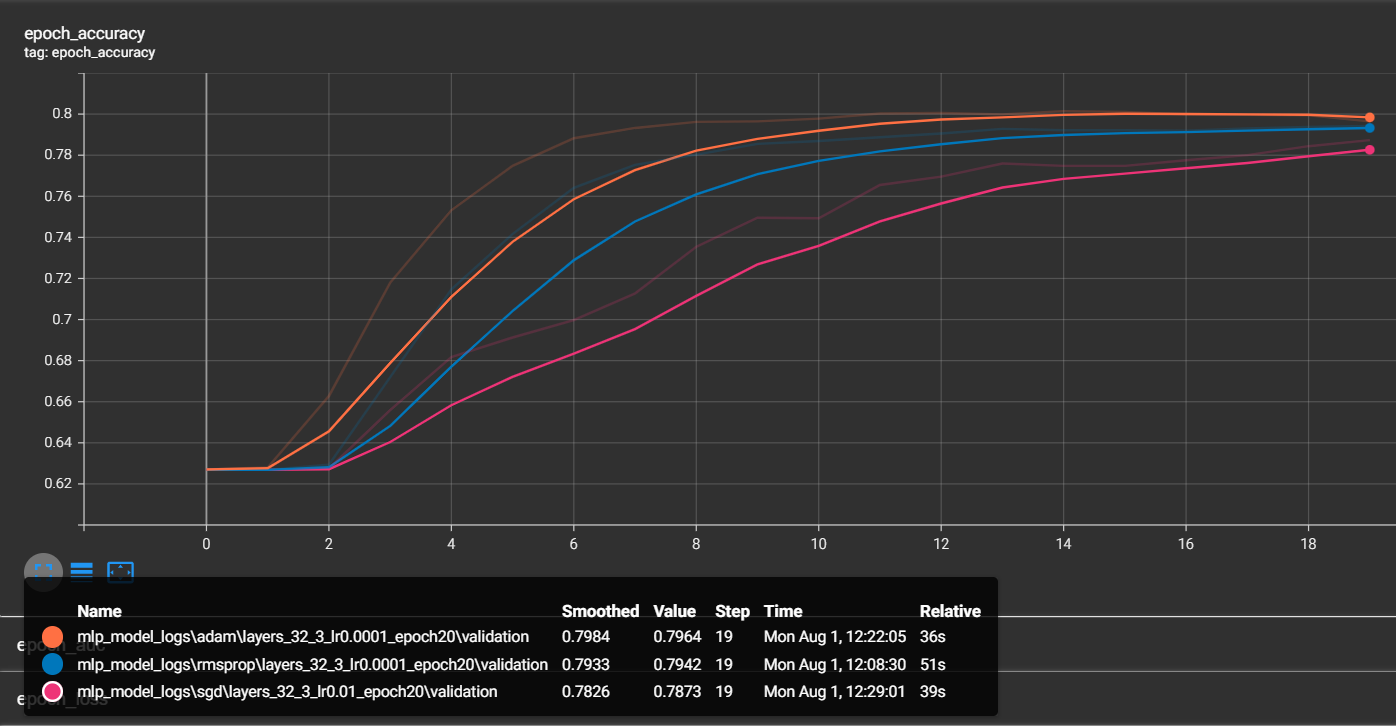

#### 5.2.MLP Models Validation Loss using diff. optimizers

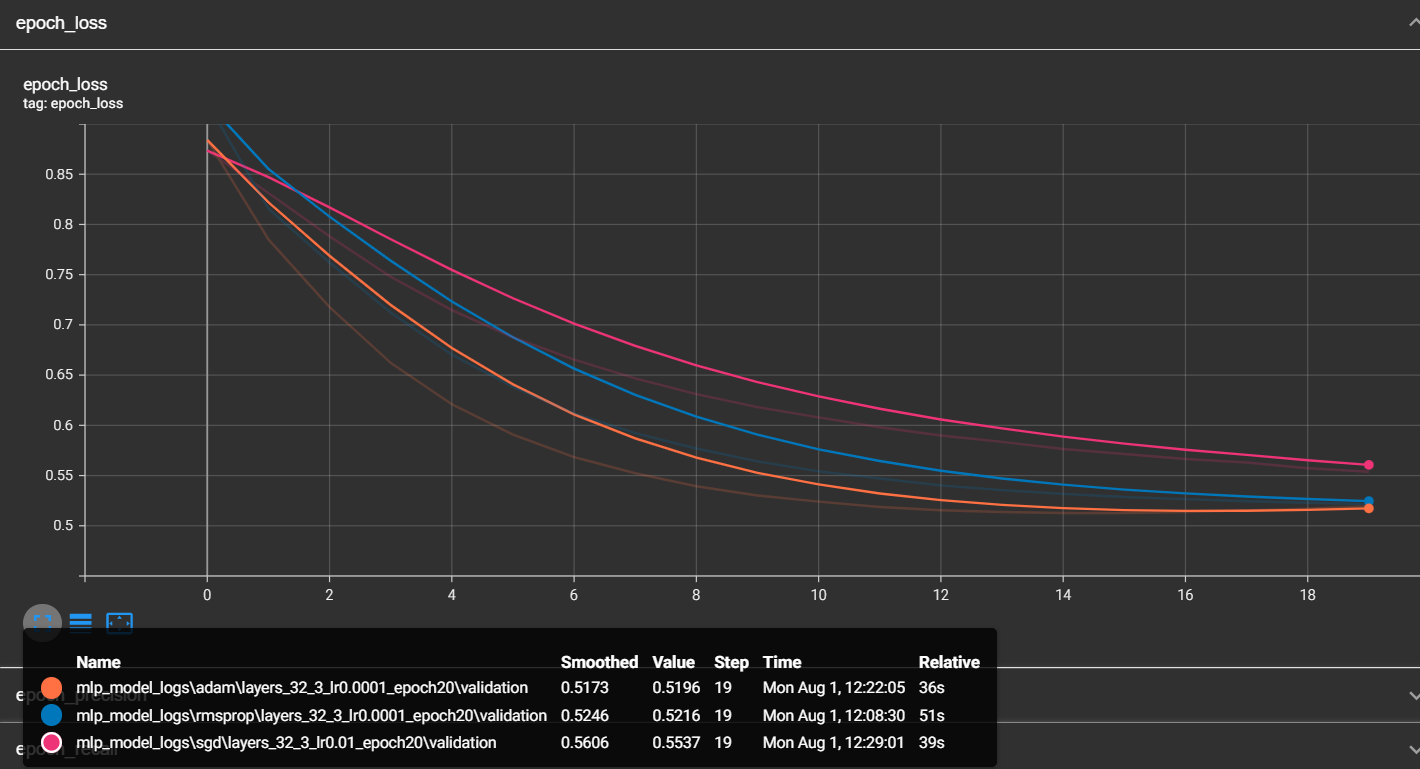

### Best model: Adam and RMSprop
Adam: learning rate = 0.0001, epoch = 20 <br>
RMSprop: learning rate = 0.0001, epoch = 20